# US Federal Public Debt, Annual Tax Revenue, Budget Deficit, and Interest Payments on Public Debt
This notebook looks at the evolution of US Federal Public Debt as a percentage of GDP, Public Debt as a percentage of Federal annual tax revenue, as well as annual public deficit as a percentage of GDP. Wherever possible I make use of data series with quarterly frequencies and annual amounts provided by [FRED](https://fred.stlouisfed.org). To calculate annual budget deficits, I sum up the amounts from the trailing four quarters. This approach ensures accuracy despite using non-seasonally adjusted data.

In all time series and graphs, the reading for the start of the quarter designates the amount for the end of the quarter. I.e. total federal debt of $28,859,125 mln for 2024-10-01 designates the amount for the end of the quarter that started on 2024-10-01.

It's not sufficient to just look at the size of the public debt. While the size of public debt may appear prodigious, understanding its true burden requires deeper examination.

1. Since public debt is predominantly serviced through tax revenue, which depends on GDP, examining the debt-to-GDP and debt-to-tax-revenue ratios is essential. As you will see below, both are slowly inching higher. For tax revenue, I use the sum of Personal current taxes, Taxes on production and imports, Taxes on corporate income, and Taxes from the rest of the world.
2. The costs of servicing it to GDP. Despite the growing debt, the ratio of interest outlays to GDP is still below the levels of the 80s but is quickly rising, it is also above the average of 2.03% calculated since 1969. It exceeded 3\% of GDP for the first time in the 21<sup>st</sup> century.
3. The cause of increases in the debt &mdash; the public deficit &mdash; and what percentage of GDP it takes.
4. It's representation in _real_ USD values. The majority of statements about the US Federal debt talk about its nominal value, however the recent bout of inflation has been conducive to shrinking its real value. I look at it at the very end of the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

In [3]:
# Human readable column names for DataFrames
FEDERAL_DEBT = 'Federal Debt'
FEDERAL_DEBT_TO_GDP = 'Federal Debt, as % of GDP'
FEDERAL_TAX_REVENUE = 'Federal Annual Tax Revenue'
FEDERAL_DEBT_TO_TAX = 'Federal Debt, as % of Annual Tax Revenue'
FEDERAL_BUDGET_DEFICIT = 'Federal Budget Deficit'
FEDERAL_DEFICIT_TO_GDP = 'Federal Deficit, as % of GDP'
FEDERAL_DEBT_INTEREST = 'Federal Debt Annual Interest Outlays'
FEDERAL_DEBT_INTEREST_TO_GDP = 'Federal Debt Interest Outlays, as % of GDP'

### Federal Debt and Tax Receipts
There are five relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `GFDEBTN` &mdash; Federal Debt: Total Public Debt in millions (quarterly frequency). This series accounts for both federal debt held by the public as well as US intragovernmental debt.
* `W006RC1Q027SBEA` &mdash; Federal government current tax receipts in billions (quarterly frequency, seasonally adjusted annual rate). An alternative could be to use `NA000327Q`, which returns quarterly tax revenues not seasonally adjusted to an annual rate, and resample it to return annual tax revenues using the sum of the trailing 4 quarters. In this notebook I use `W006RC1Q027SBEA`.
* `GFDEGDQ188S` &mdash; Federal Debt: Total Public Debt as Percent of Gross Domestic Product (quarterly frequency, seasonally adjusted). Like `GFDEBTN` this series accounts for both federal debt held by the public as well as intragovernmental debt.
* `FYGFDPUN` &mdash; unlike `GFDEBTN` this series accounts only for federal debt held by the public in millions (quarterly frequency).
* `FYGFGDQ188S` &mdash; unlike `GFDEGDQ188S` this series accounts only for federal debt held by the public as percent of GDP (quarterly frequency).

In this notebook I look at the public portion of US federal debt `FYGFDPUN` rather than its total amount `GFDEBTN` (i.e. I exclude the part the government owns to itself). If you want to include it, please replace `FYGFDPUN` with `GFDEBTN` and `FYGFGDQ188S` with `GFDEGDQ188S`. It is more accurate to use the public portion of the US debt for analysis as the part captured by the Intragovernmental Holdings Debt (IGHD) is but an instrument to balance liquidity in the US federal budget system (it's, however, taken into acount when determining the US debt ceiling).

In [4]:
# GFDEBTN         -- Federal Debt: Total Public Debt in millions (quarterly frequency)
# W006RC1Q027SBEA -- Federal government current tax receipts in billions (quarterly frequency, seasonally adjusted)
# GFDEGDQ188S     -- Federal Debt: Total Public Debt as Percent of Gross Domestic Product (quarterly frequency)
fred_pub_debt_and_tax_rev = web.get_data_fred(['FYGFDPUN', 'W006RC1Q027SBEA', 'FYGFGDQ188S'],
                                              start=report_start, end=report_end)

# Converting current tax receipts to millions
fred_pub_debt_and_tax_rev.W006RC1Q027SBEA *= 1000 

# In case you prefer to use NA000327Q instead of W006RC1Q027SBEA
# Converting current tax recepits from quarterly to annual (trailing 4 quarters)
# fred_pub_debt_and_tax_rev.NA000327Q = fred_pub_debt_and_tax_rev.NA000327Q.rolling(4).sum()

# Adding as a new column in the main DataFrame for Federal Debt to Annual Tax Revenue Ratio
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX] = fred_pub_debt_and_tax_rev.FYGFDPUN / fred_pub_debt_and_tax_rev.W006RC1Q027SBEA * 100

###  Interest Payments on Federal Public Debt
The only useful dataseries provided by [FRED](https://fred.stlouisfed.org) is:
* `FYOINT` &mdash; Federal Outlays: Interest in millions (annual frequency). Unfortunately it's only avialable
with annual frequencies. So I need to upsample it into quarterly frequencies and deal with the change in
fiscal year ends starting from 1977 (from end of June in prior years to end of September from 1977 onwards). As a result a correct number for ratios involving interest outlays is available only for the third quarter of each year.
* `GDP` &mdash; Gross Domestic Product in in billions (quarterly frequency, from 1930, seasonally adjusted annual rate). This series lets me calculate annual interest outlays to GDP ratio with a frequency of every quarter.

In [5]:
# FYOINT -- Federal Outlays: Interest in millions (annual frequency)
interest_payments = web.get_data_fred('FYOINT', start=report_start, end=report_end)
gdp = web.get_data_fred('GDP', start=report_start, end=report_end)

# Converting to Series, adjusting units from billions to millions, and making frequencies explicit 
gdp = gdp.GDP * 1000
gdp = gdp.asfreq('QS')

# In years up to 1976 fiscal year end was end of June, in the years thereafter
# end of September. This needs to be properly accounted for when upsampling into quarter frequency.
interest_payments_A_JUN = interest_payments[:'1976'].asfreq('YE-JUN')
interest_payments_A_SEP = interest_payments['1977':].asfreq('YE-SEP')

interest_payments_QS = interest_payments_A_JUN.resample('QS').bfill(limit=4).FYOINT
interest_payments_QS_from_1977 = interest_payments_A_SEP.resample('QS').bfill(limit=4).FYOINT

# Add 4 missing quarters with missing quarters for backfilling
missing_quarters = pd.Series(np.nan, index=pd.date_range("1976-07-01", periods=4, freq="QS"))
interest_payments_QS_from_1977 = pd.concat([missing_quarters, interest_payments_QS_from_1977]).bfill(limit=4)
interest_payments_QS = pd.concat([interest_payments_QS, interest_payments_QS_from_1977])

# Adding as a new column in the main DataFrame for interest payments on public debt
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST] = interest_payments_QS
# Adding as a new column in the main DataFrame for nterest payments on public debt to Annual Tax Revenue Ratio
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_GDP] = interest_payments_QS / gdp * 100

# Best guess for the last year
fred_pub_debt_and_tax_rev.ffill(limit=3, inplace=True)

### Federal Budget Deficit and Budget Deficit to GDP
There are a few relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `M318501Q027NBEA` &mdash; Federal government budget surplus in billions (quarterly frequency, from 1957, not seasonally adjusted). Unfortunately it is not frequently updated and lacks the last quarters
* `MTSDS133FMS` &mdash; Federal Surplus or Deficit in millions (monthly frequency, from 1980, not seasonally adjusted). This one contains the most recent months.


In this notebook I use `M318501Q027NBEA` as the basis. I extend it with the most recent quarters by appropriately resampling `MTSDS133FMS`. Since federal budget has predominantly featured deficit lately, I convert surpluses into deficits &mdash; i.e. a positive amount designates a deficit, while a negative denotes a surplus. Since national debt ratios are typically annualized, I resample it to return annual budget deficits using the sum of the trailing 4 quarters. This way I get a new annual budget deficit for every quarter comprising the most recent 4 quarters. Using the sum of the trailing four quarters also compensates for using a non-seasonally adjusted data for federal budget deficit, which is handy when caculating the budget deficit to GDP ratio.

Using the `GDP` series, I calculate the annual budget deficit to GDP ratio on a quarterly basis.

In [6]:
# M318501Q027NBEA -- Federal government budget surplus in billions (quarterly frequency, from 1957)
# MTSDS133FMS     -- Federal Surplus or Deficit in millions (monthly frequency, from 1980)

# Actually, MTSDS133FMS tracks surpluses, but I'll convert it to deficits
fed_budget_deficit_monthly = web.get_data_fred('MTSDS133FMS', start=report_start, end=report_end)
fed_budget_deficit_quarterly = web.get_data_fred('M318501Q027NBEA', start=report_start, end=report_end)

# Convert from DataFrames to Series, converting budget surpluses to deficits,
# and adjusting units from billions to millions where appropriate
fed_budget_deficit_monthly = fed_budget_deficit_monthly.MTSDS133FMS * -1
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.M318501Q027NBEA * -1000

# Making frequencies explicit
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.asfreq('QS')
fed_budget_deficit_monthly = fed_budget_deficit_monthly.asfreq('MS')

# Aligning frequencies
fed_budget_deficit_quarterly_from_fy_1981Q1 = fed_budget_deficit_monthly.resample('QS').sum()

# Extending M318501Q027NBEA with new quarterly data
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.combine_first(fed_budget_deficit_quarterly_from_fy_1981Q1)

# Converting quarterly budget deficit into annual (trailing 4 quarters)
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.rolling(4).sum()

# Adding as a new column in the main DataFrame for budget deficits
fred_pub_debt_and_tax_rev[FEDERAL_BUDGET_DEFICIT] = fed_budget_deficit_quarterly

# Adding as a new column in the main DataFrame for deficit to gdp
fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP] = (fed_budget_deficit_quarterly / gdp * 100).ffill()

# Truncating to start of calendar year 1970
fred_pub_debt_and_tax_rev = fred_pub_debt_and_tax_rev.loc['1970':]

### Preparing factors for conversion from nominal to real amounts using the GDP Implicit Price Deflator

In [7]:
nom_2_real_conv_factors = web.get_data_fred('GDPDEF', start=report_start, end=report_end)

nom_2_real_conv_factors['conv_factor'] = nom_2_real_conv_factors.GDPDEF.iloc[-1] / nom_2_real_conv_factors.GDPDEF

# Convert into pandas.Series
nom_2_real_conv_factors = nom_2_real_conv_factors.conv_factor

### Visualization of prepared data

In [8]:
fred_pub_debt_and_tax_rev.rename(
    columns={'GFDEBTN': FEDERAL_DEBT, 'W006RC1Q027SBEA': FEDERAL_TAX_REVENUE,
             'GFDEGDQ188S': FEDERAL_DEBT_TO_GDP, 'M318501Q027NBEA': FEDERAL_BUDGET_DEFICIT,
             'FYGFDPUN': FEDERAL_DEBT, 'FYGFGDQ188S': FEDERAL_DEBT_TO_GDP},
    inplace=True)

In [9]:
fred_pub_debt_and_tax_rev

,Federal Debt,Federal Annual Tax Revenue,"Federal Debt, as % of GDP","Federal Debt, as % of Annual Tax Revenue",Federal Debt Annual Interest Outlays,"Federal Debt Interest Outlays, as % of GDP",Federal Budget Deficit,"Federal Deficit, as % of GDP"
DATE,,,,,,,,
1970-01-01,280814.0,135748.0,26.71366,206.864190,14380.0,1.367960,-3.967000e+03,-0.377378
1970-04-01,274924.0,136872.0,25.75702,200.862119,14380.0,1.347230,2.845000e+03,0.266542
1970-07-01,282367.0,132800.0,25.99923,212.625753,14841.0,1.366500,8.143000e+03,0.749775
1970-10-01,291242.0,132300.0,26.75362,220.137566,14841.0,1.363301,1.138100e+04,1.045464
1971-01-01,292043.0,133248.0,25.72712,219.172520,14841.0,1.307397,1.611500e+04,1.419629
...,...,...,...,...,...,...,...,...
2023-10-01,26960227.0,2952220.0,95.27603,913.218764,881651.0,3.115708,1.782428e+06,6.299007
2024-01-01,27533422.0,3029856.0,96.18976,908.736983,881651.0,3.080104,1.658235e+06,5.793149
2024-04-01,27634108.0,3078799.0,95.23514,897.561289,881651.0,3.038425,1.570359e+06,5.411911


#### US Federal Public Debt, Annual Tax Revenue, and Annual Budget Deficit from 1990
Throughout the rest of this notebook budget deficits are displayed as positive numbers, while surpluses as negative ones. Annual interest outlays are remarkably small due to the Fed keeping treasury rates down (US treasury paid an average interest rate of 3.4% as of Q3 2024). However interest payments are rapidly growing.

In [10]:
TOTAL_DEBT_GRAPH_TITLE = 'US Federal Public Debt, Annual Tax Revenue, Annual Budget Deficit, and Annual Interest Outlays'
TAXREV_DEFICIT_TITLE = 'US Annual Tax Revenue and Budget Deficit'
LEFT_Y_AXIS_LABEL = 'Billions of USD'
INTOUTLAYS_TITLE = 'US Annual Interest Outlays'

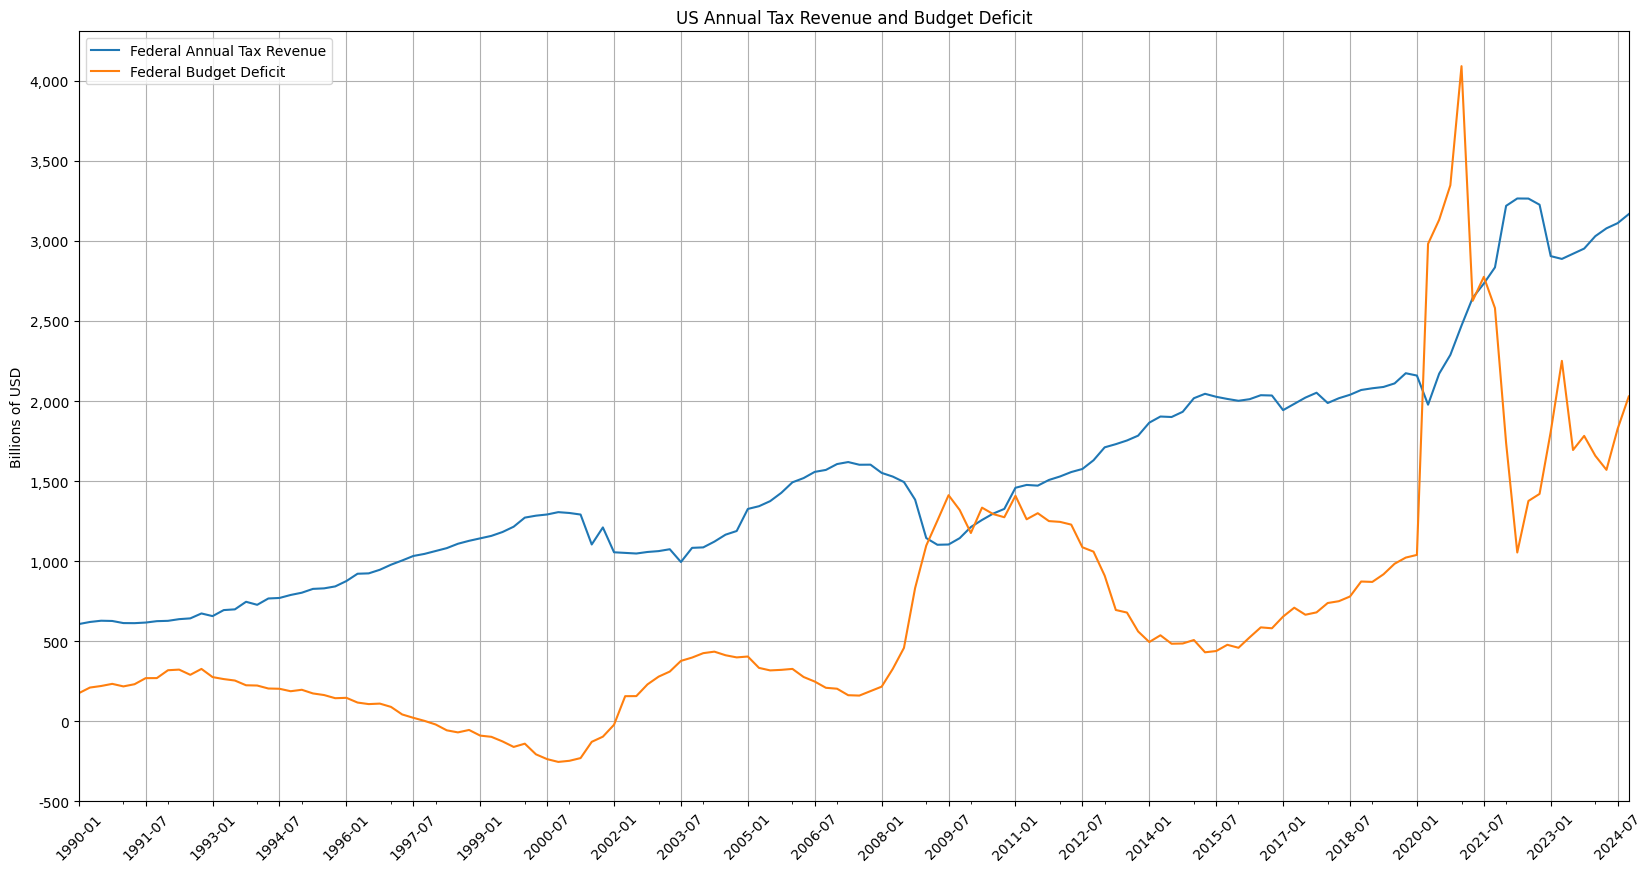

In [11]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, [FEDERAL_TAX_REVENUE, FEDERAL_BUDGET_DEFICIT]]
ax = shorter_series.plot(figsize=(20,10), grid=True, yticks=range(-500000, 4100000, 500000),
                     title=TAXREV_DEFICIT_TITLE, ylabel=LEFT_Y_AXIS_LABEL,
                     xticks=shorter_series.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

The dataseries for the below graph has an annual frequency, and is updated in Q3 of each year.

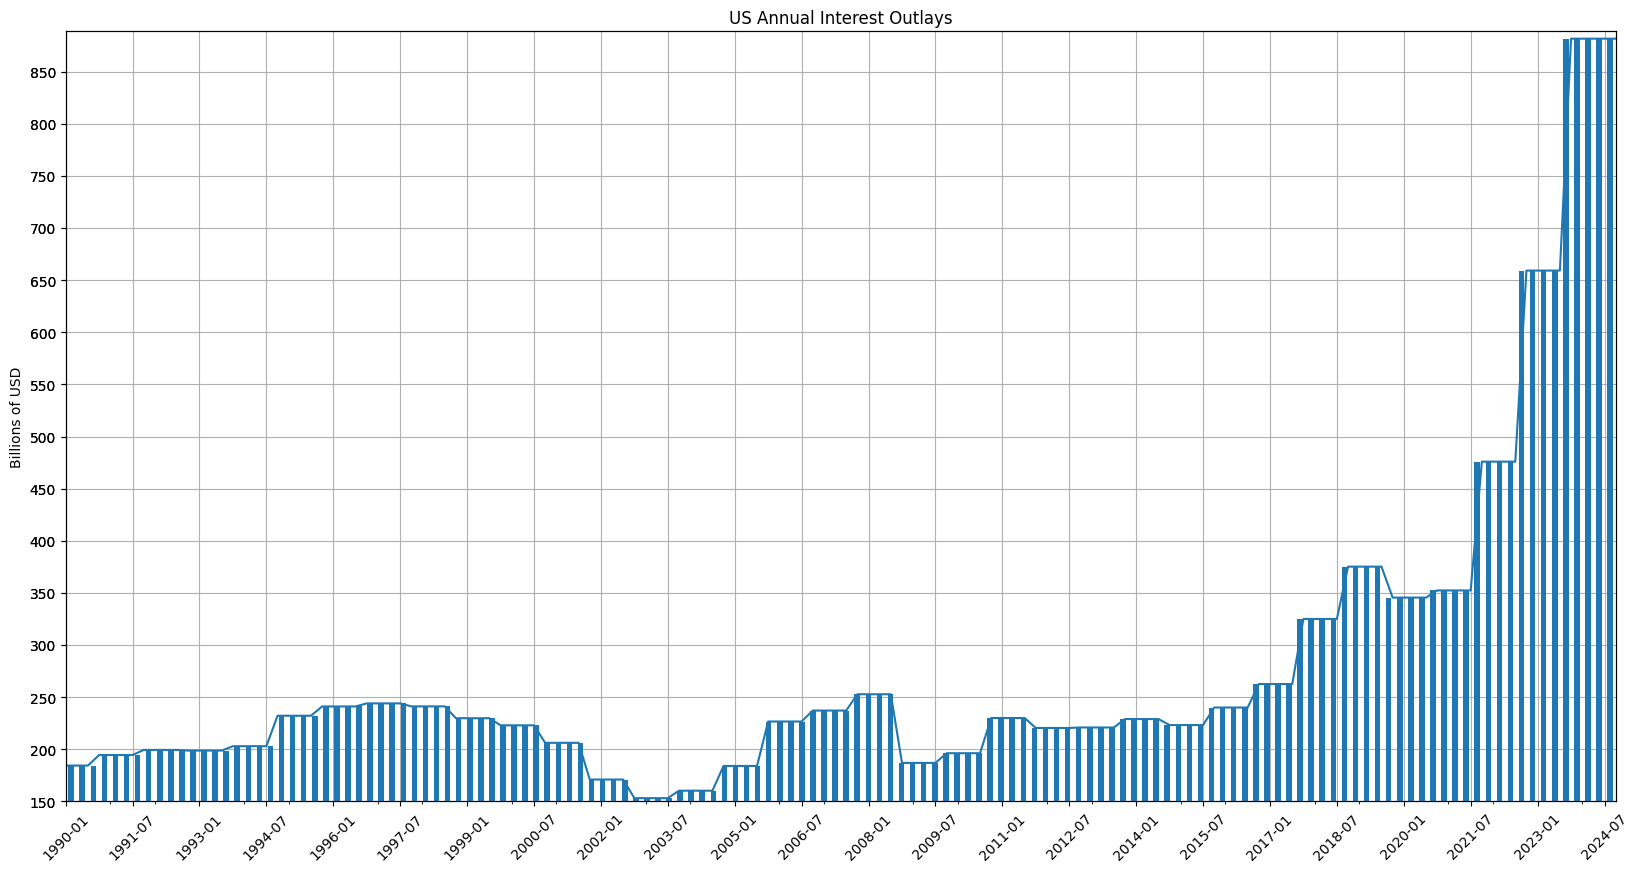

In [12]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, FEDERAL_DEBT_INTEREST]
y_max = int(shorter_series.max())
ax = shorter_series.plot(figsize=(20,10), grid=True, yticks=range(150000, y_max, 50000),
                         ylim=(150000, y_max+7000),
                         title=INTOUTLAYS_TITLE, ylabel=LEFT_Y_AXIS_LABEL,
                         xticks=shorter_series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
shorter_series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

#### US Federal Public Debt to GDP, Federal Debt to Annual Tax Revenue, Annual Federal Deficit to GDP, and Annual Interest Outlays to GDP ratios
Despite the growing debt, the ratio of interest outlays to tax revenues is below the levels of the 80s.

In [13]:
DEBT_RATIOS_GRAPH_TITLE = '10 Year Treasury Yield, US Federal Public Debt to GDP, Debt to Annual Tax Revenue, and Annual Federal Deficit to GDP ratios'
DEBT_RATIOS_GRAPH_TITLE_1 = 'US Federal Public Debt to GDP and Debt to Annual Tax Revenue'
DEBT_RATIOS_GRAPH_TITLE_1_1 = 'US Federal Public Debt to GDP'
DEBT_RATIOS_GRAPH_TITLE_1_2 = 'US Federal Public Debt to Annual Tax Revenue'
DEBT_RATIOS_GRAPH_TITLE_2 = '10 Year Treasury Yield and Annual Federal Deficit to GDP ratios'
DEBT_RATIOS_GRAPH_TITLE_3 = 'Interest Outlays, as % of GDP'
DEBT_RATIOS_GRAPH_TITLE_4 = 'Annual Federal Deficit to GDP'
LEFT_Y_AXIS_LABEL2 = 'Federal Debt to GDP, Federal Debt to Annual Tax Revenue'
RIGHT_Y_AXIS_LABEL = '10 Year Treasury Yield, Annual Federal Deficit to GDP, Annual Interest Outlay to Tax Revenue'
DEBT_RATIOS_GRAPH_TITLE_SHORT = '10 Year Treasury Yield, Annual Federal Deficit to GDP, and Federal Debt Interest Outlays to Tax Revenue ratios'
LABEL_DEBT_TO_GDP = 'Mean level of Federal Public Debt to GDP'
LABEL_DEBT_TO_TAX = 'Mean level of Federal Public Debt to Annual Tax Revenue'
LABEL_BUDGET_DEFICIT_TO_GDP = 'Mean level of Federal Deficit to GDP'
LABEL_INTEREST_OUTLAYS_TO_GDP = 'Mean level of Federal Debt Interest Outlays to GDP'
FEDERAL_DEBT_IN_REAL_VALUES = 'US Federal Public Debt in Nominal and Real Amounts'
IN_USD_FORMATER = ' in {:%Y-%m} USD'

#### US Total Federal Public Debt to GDP and Federal Debt to Tax Revenues ratios

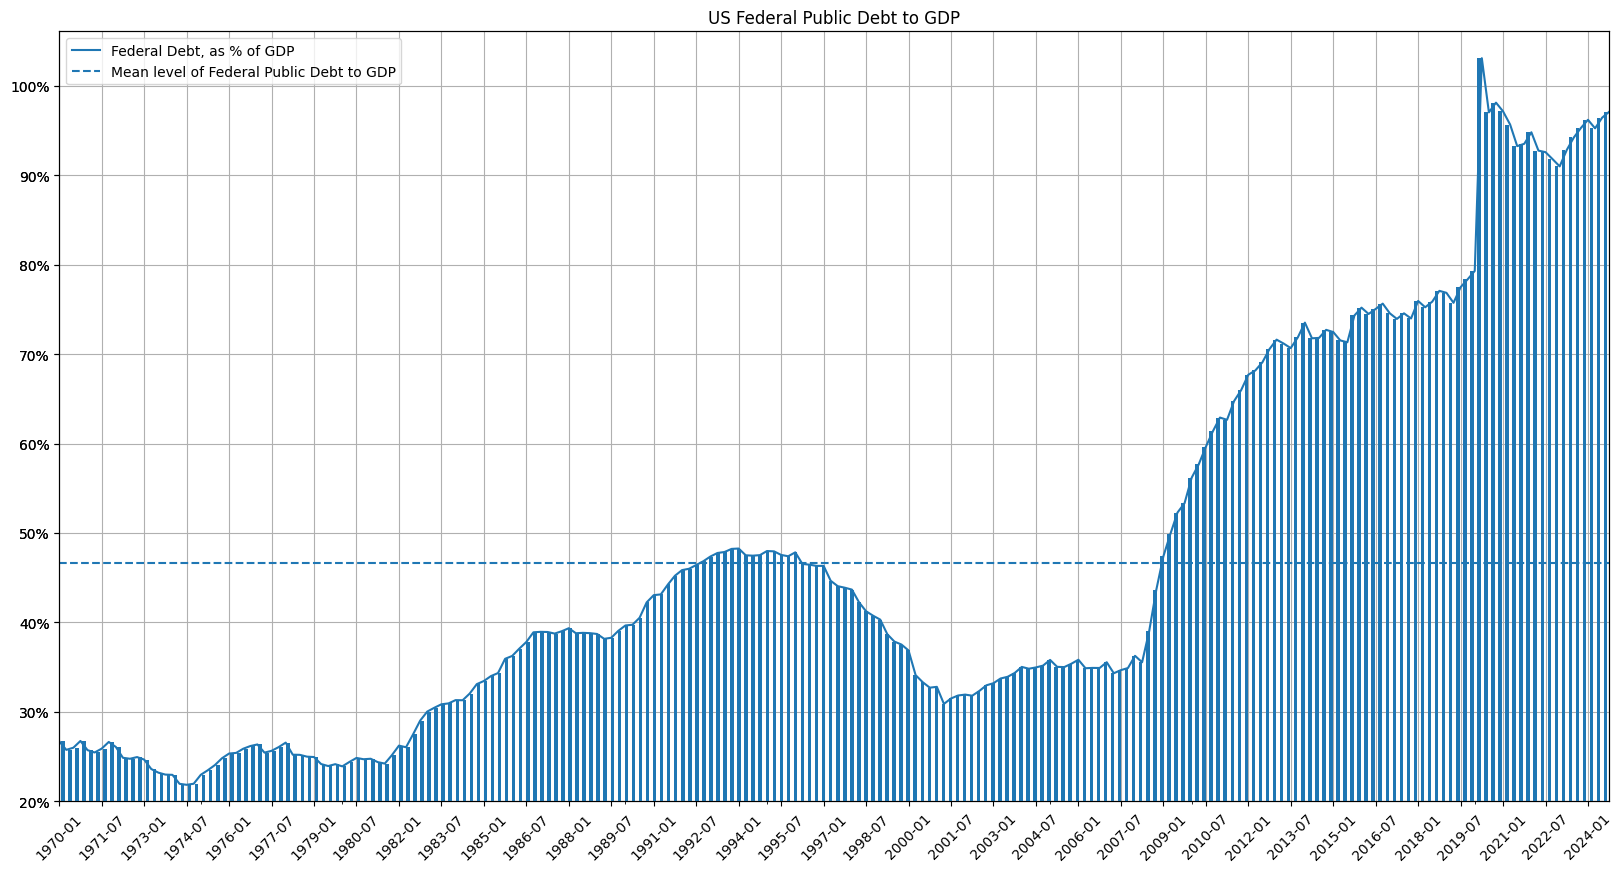

In [14]:
ax = fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].plot(
                        figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_1,
                        xticks=fred_pub_debt_and_tax_rev.index[::6], xlabel='', rot=45,
                        yticks=np.arange(20, 110, 10), ylim=(20, fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].max() + 3))
ax2 = ax.twiny()
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(y=fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_DEBT_TO_GDP)
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_pub_debt_and_tax_rev.index[::6])))

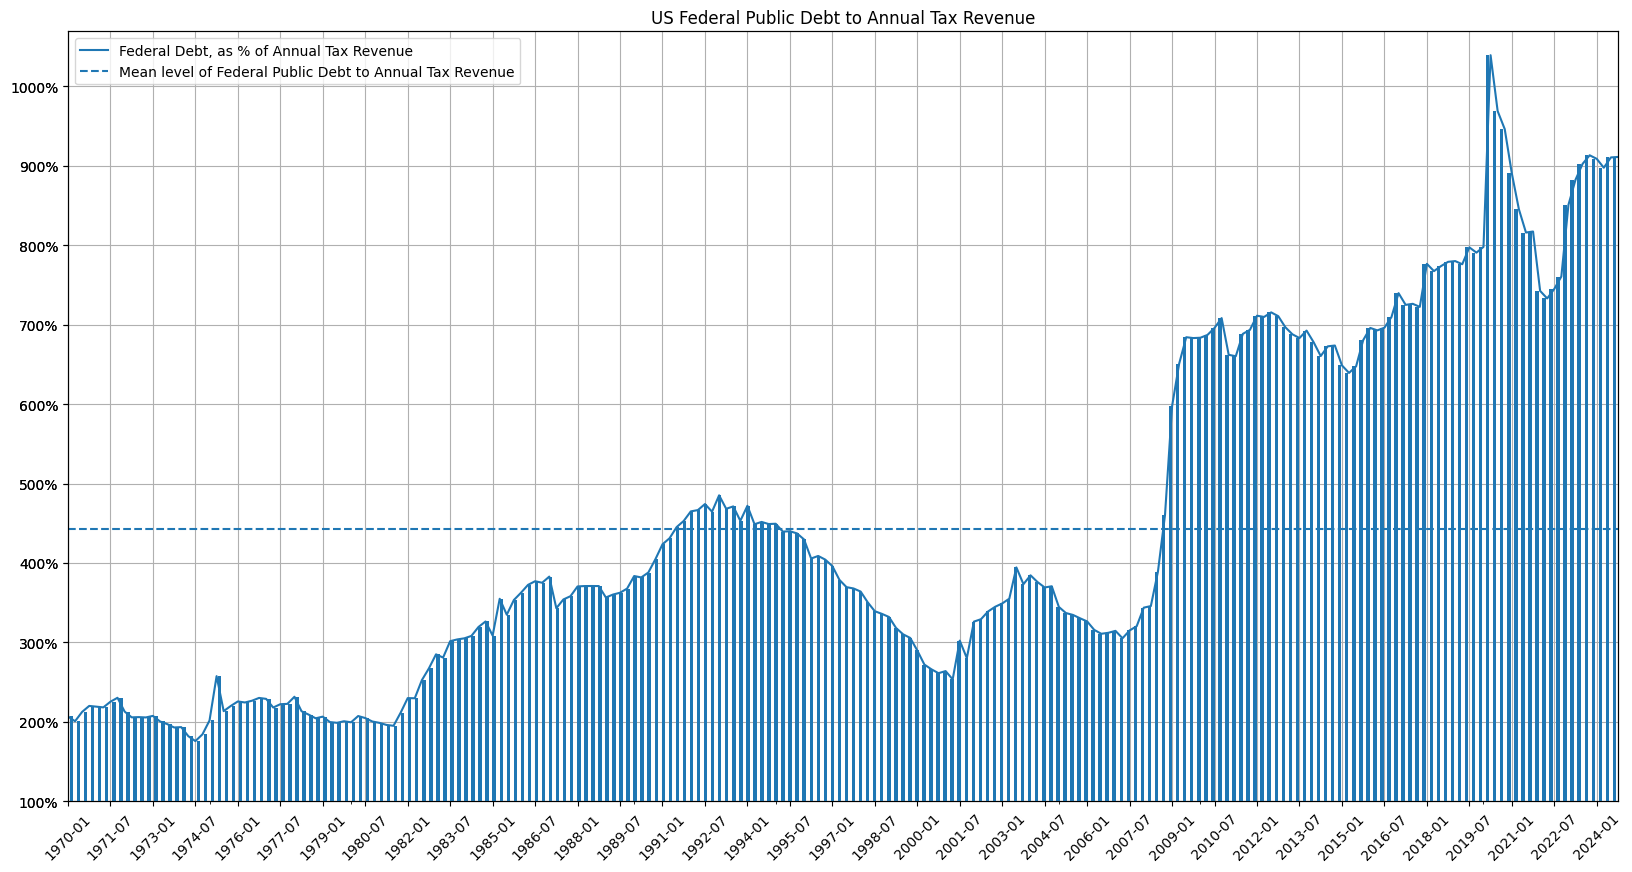

In [15]:
ax = fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].plot(
                        figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_2,
                        xticks=fred_pub_debt_and_tax_rev.index[::6], xlabel='', rot=45,
                        yticks=np.arange(100, 1100, 100), ylim=(100, fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].max() + 30))
ax2 = ax.twiny()
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].mean(), c='#1f77b4', ls='--',
           label=LABEL_DEBT_TO_TAX)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_pub_debt_and_tax_rev.index[::6])))

#### Budget deficit to GDP ratio

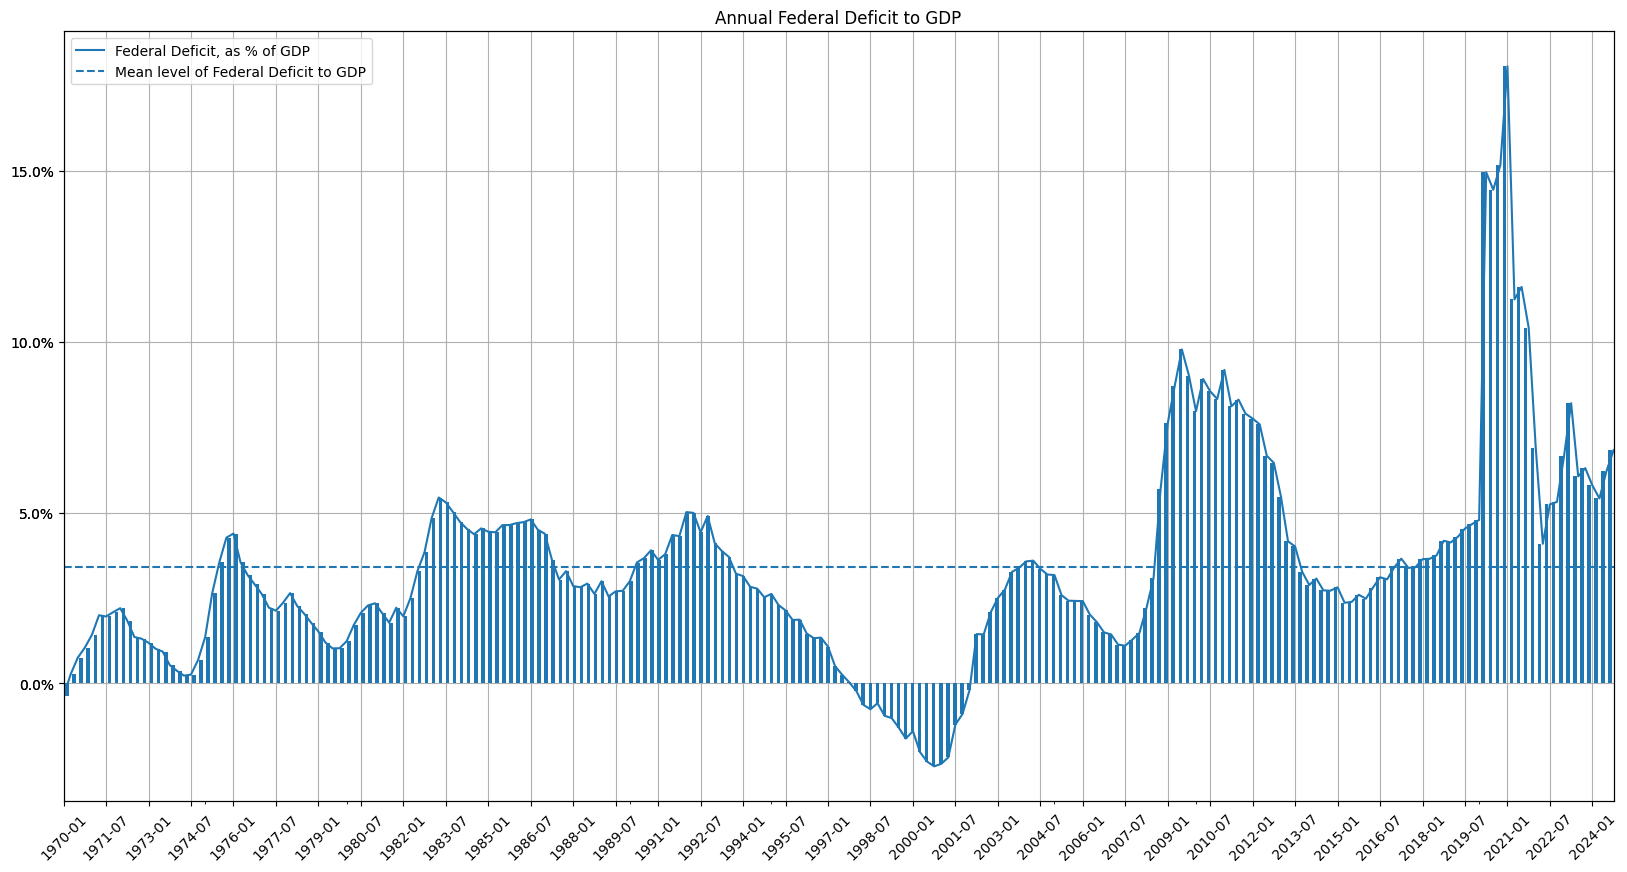

In [16]:
ax = fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP].plot(
        figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_4,
        xticks=fred_pub_debt_and_tax_rev.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_BUDGET_DEFICIT_TO_GDP)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_pub_debt_and_tax_rev.index[::6])))

#### Annual Interest Outlays to GDP ratio

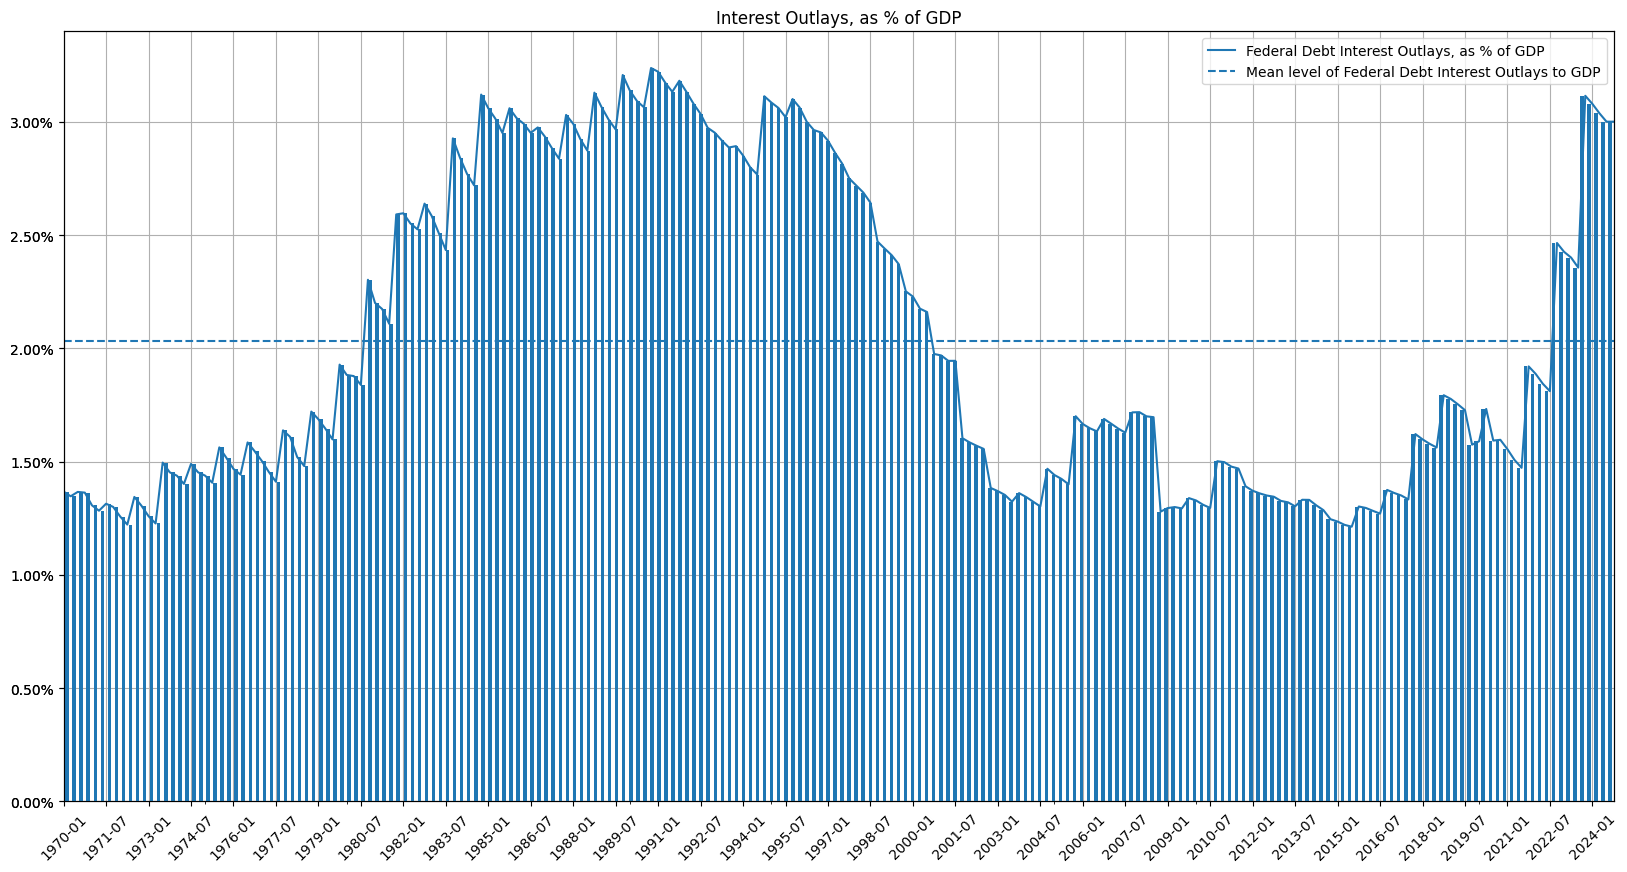

In [17]:
# Unfortunately updated only annually, therefore accurate only for Q3.
ax = fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_GDP].plot(
        figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_3,
        xticks=fred_pub_debt_and_tax_rev.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_GDP].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEBT_INTEREST_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_INTEREST_OUTLAYS_TO_GDP)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_pub_debt_and_tax_rev.index[::6])))

In [18]:
print('Mean level of Federal Debt to GDP: {:.2f}%'.format(
    fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].mean()))
print('Mean level of Federal Debt to Annual Tax Revenues: {:.2f}%'.format(
    fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].mean()))
print('Mean level of Budget Balance as % of GDP: {:.2f}%'.format(
    -fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP].mean()))
print('Mean level of Federal Debt Interest Outlays to GDP: {:.2f}%'.format(
    fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_GDP].mean()))

Mean level of Federal Debt to GDP: 46.65%
Mean level of Federal Debt to Annual Tax Revenues: 442.25%
Mean level of Budget Balance as % of GDP: -3.39%
Mean level of Federal Debt Interest Outlays to GDP: 2.03%


#### US Total Federal Public Debt to GDP and Federal Debt to Tax Revenues ratios from 1990 and onwards

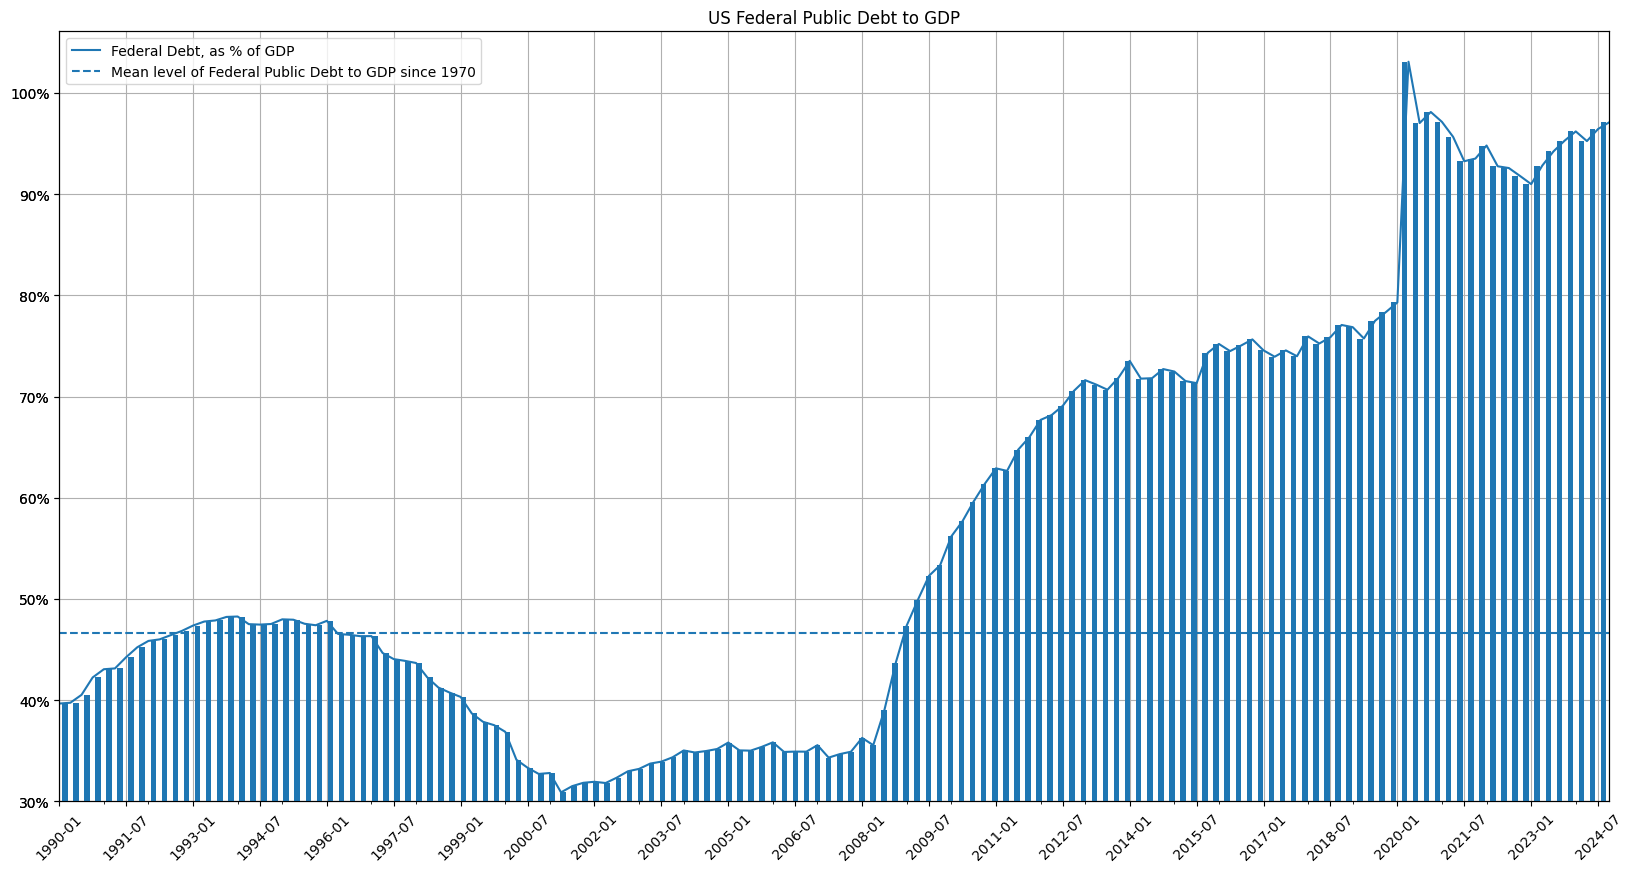

In [19]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, FEDERAL_DEBT_TO_GDP]
suffix = ' since {:%Y}'.format(fred_pub_debt_and_tax_rev.index[0])
ax = shorter_series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_1,
                         xticks=shorter_series.index[::6], xlabel='', rot=45, yticks=np.arange(30, shorter_series.max() + 3, 10),
                         ylim=(30, shorter_series.max() + 3))
ax2 = ax.twiny()
shorter_series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_DEBT_TO_GDP + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

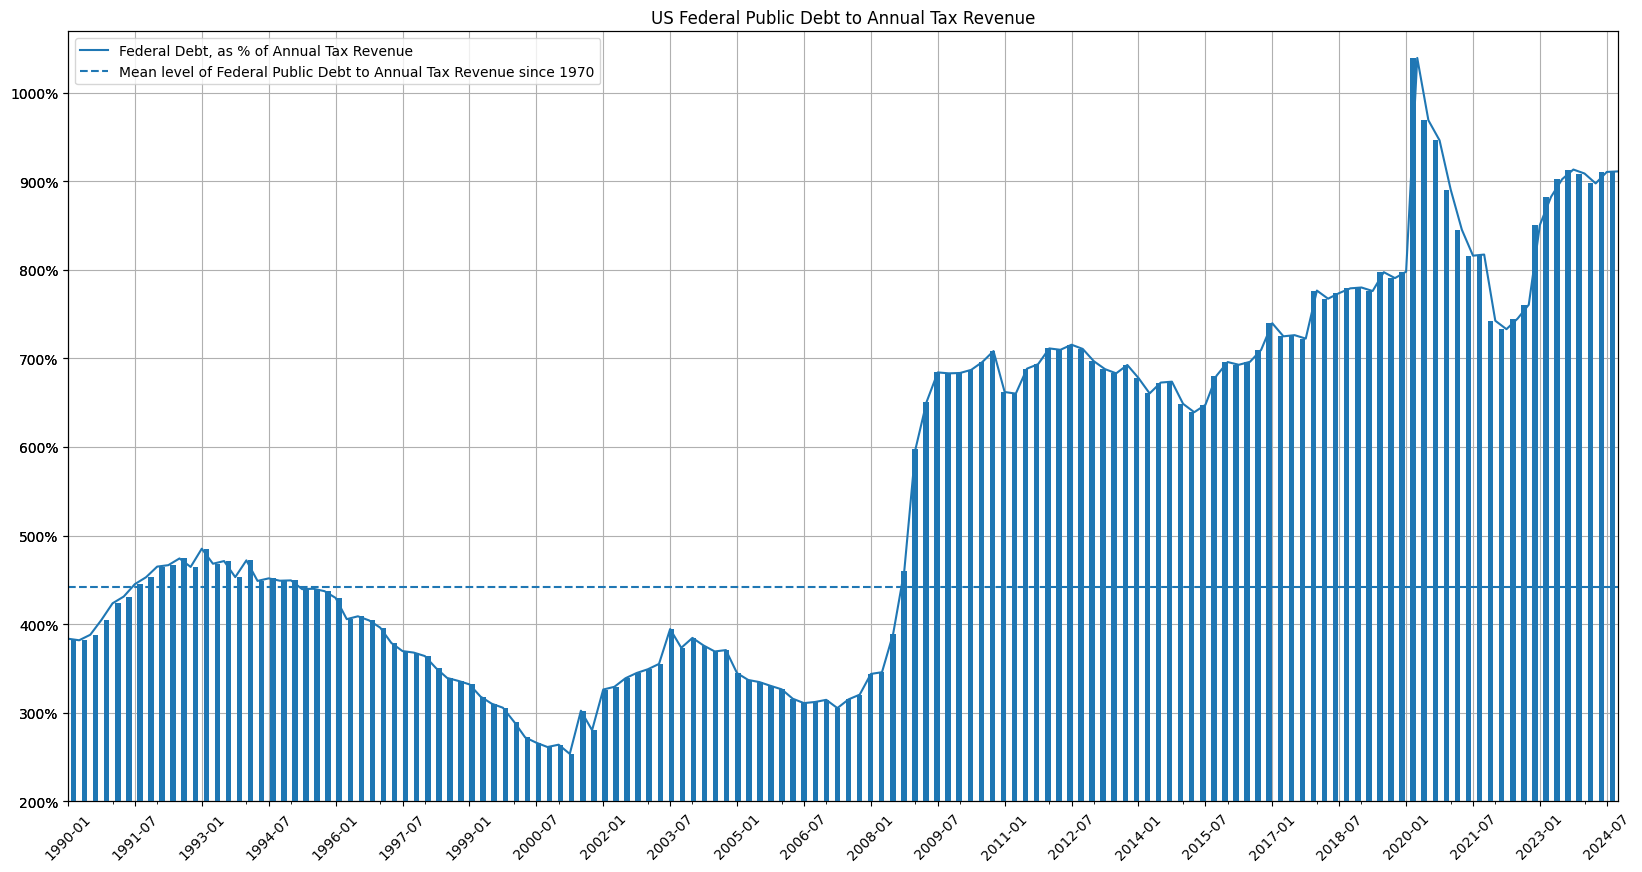

In [20]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, FEDERAL_DEBT_TO_TAX]
ax = shorter_series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_2,
                         xticks=shorter_series.index[::6], xlabel='', rot=45, yticks=np.arange(200, shorter_series.max() + 30, 100),
                         ylim=(200, shorter_series.max() + 30))
ax2 = ax.twiny()
shorter_series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].mean(), c='#1f77b4', ls='--',
           label=LABEL_DEBT_TO_TAX + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

#### 10 Year Treasury Yield, Annual Federal Deficit to GDP, and Annual Interest Outlays to Annual Tax Revenue ratios from 1990 and onwards

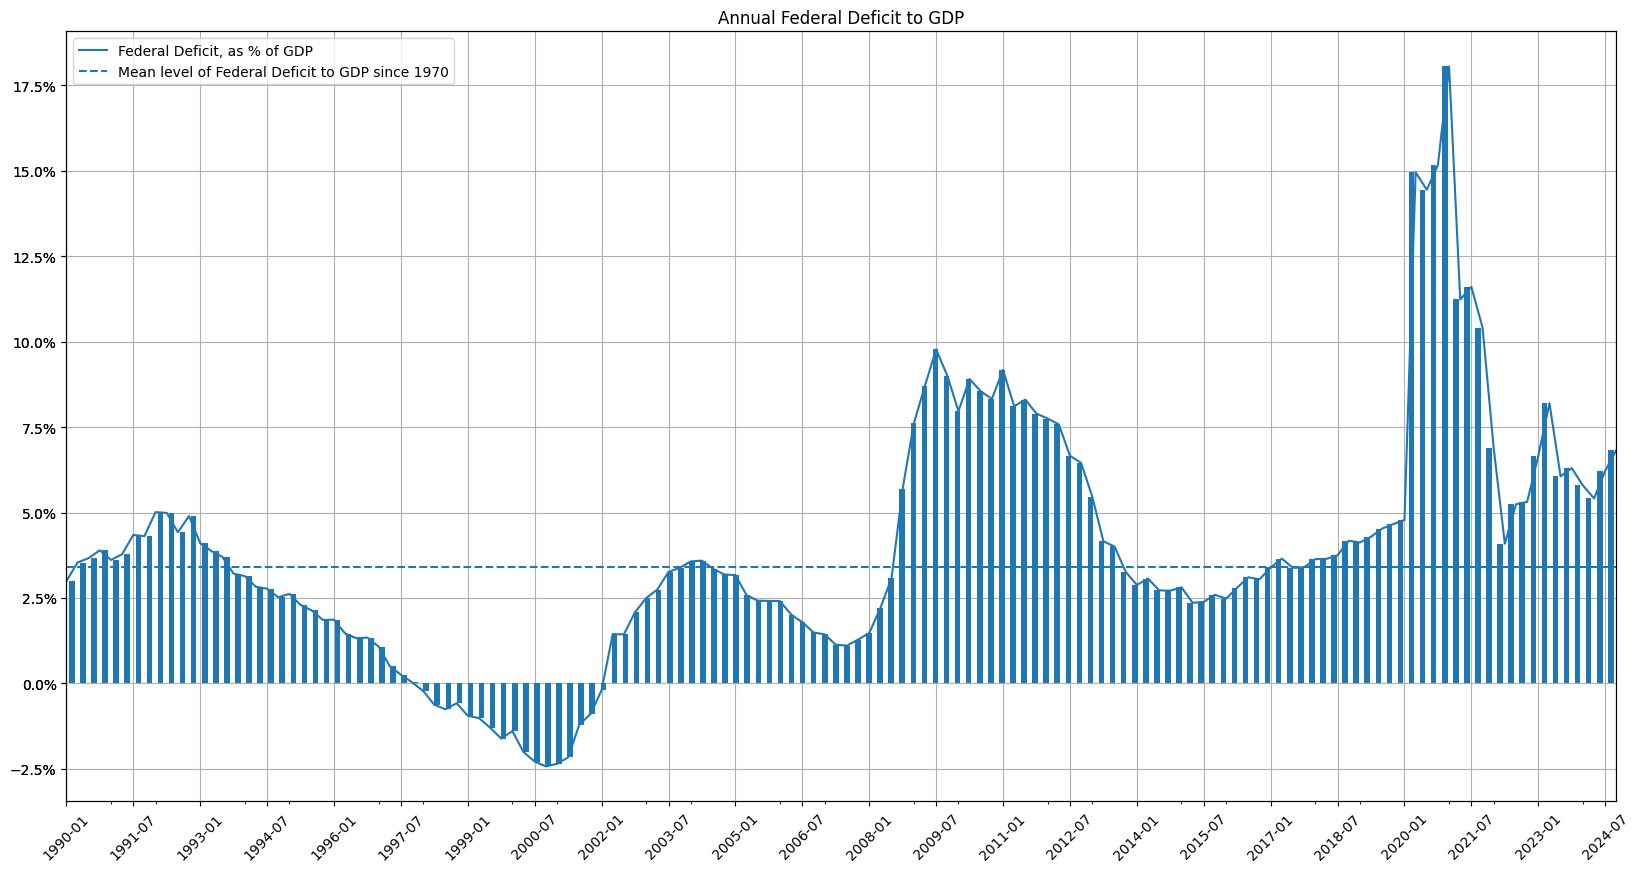

In [21]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, [FEDERAL_DEFICIT_TO_GDP, FEDERAL_DEBT_INTEREST_TO_GDP]]
ax = shorter_series.iloc[:,:1].plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_4,
                                    xticks=shorter_series.index[::6], xlabel='', rot=45,
                                    yticks=np.arange(-2.5, 20, 2.5))
ax2 = ax.twiny()
shorter_series.iloc[:,:1].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEFICIT_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_BUDGET_DEFICIT_TO_GDP + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

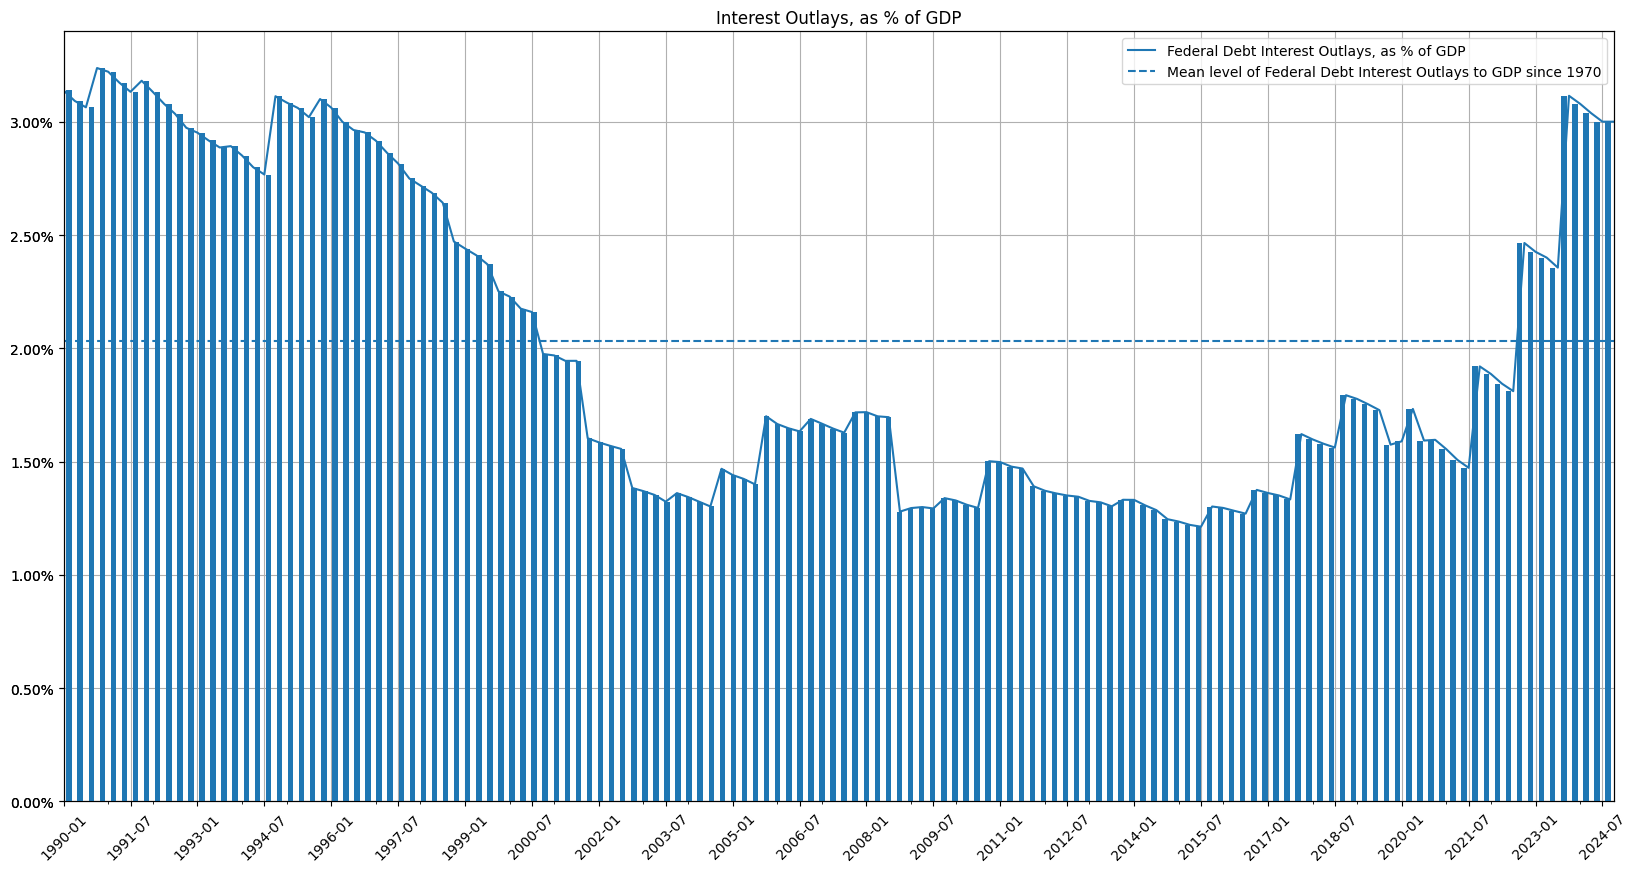

In [22]:
# Unfortunately updated only annually, therefore accurate only for Q3.
ax = shorter_series.iloc[:,1:].plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_3,
                                    linestyle='-', xticks=shorter_series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
shorter_series.iloc[:,1:].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEBT_INTEREST_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_INTEREST_OUTLAYS_TO_GDP + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

Percentage changes in the last quarter

In [23]:
df = fred_pub_debt_and_tax_rev[[FEDERAL_DEBT_TO_GDP, FEDERAL_DEBT_TO_TAX, FEDERAL_DEFICIT_TO_GDP, FEDERAL_DEBT_INTEREST_TO_GDP]]
(df.iloc[-1] - df.iloc[-2]).\
    rename('Changes over quarter starting on %s' % df.index[-1].date()).apply('{:+.4f}%'.format)

Federal Debt, as % of GDP                     +0.6625%
Federal Debt, as % of Annual Tax Revenue      +0.5972%
Federal Deficit, as % of GDP                  +0.6083%
Federal Debt Interest Outlays, as % of GDP    +0.0000%
Name: Changes over quarter starting on 2024-10-01, dtype: object

In [24]:
print('US Federal Debt grew by {:+.2f}bn in quarter starting on {:%Y-%m-%d}'
      .format((fred_pub_debt_and_tax_rev.iloc[-1,0]-fred_pub_debt_and_tax_rev.iloc[-2,0])/1000., df.index[-1]))

US Federal Debt grew by +533.41bn in quarter starting on 2024-10-01


### Federal Debt in current dollar amounts
The majority of statements about the US Federal debt talk about its nominal value, however the recent bout of inflation has been conducive to shrinking its real value. In the below part of the notebook I look at the evolution of US Federal Debt using the current dollar amounts. I use the GDP Implicit Price Deflator to obtain past real values of the Federal Debt. This is similar to how real GDP is calculated.

I make use of the following dataseries provided by [FRED](https://fred.stlouisfed.org)
* `GDPDEF` &mdash; Gross Domestic Product: Implicit Price Deflator (quarterly frequency, seasonally adjusted).

In [25]:
real_pub_debt = pd.concat([fred_pub_debt_and_tax_rev.iloc[:,0],
                          (fred_pub_debt_and_tax_rev.iloc[:,0] * nom_2_real_conv_factors).dropna()], axis=1)
real_pub_debt.rename(columns= {0: 'Real ' + FEDERAL_DEBT}, inplace=True)

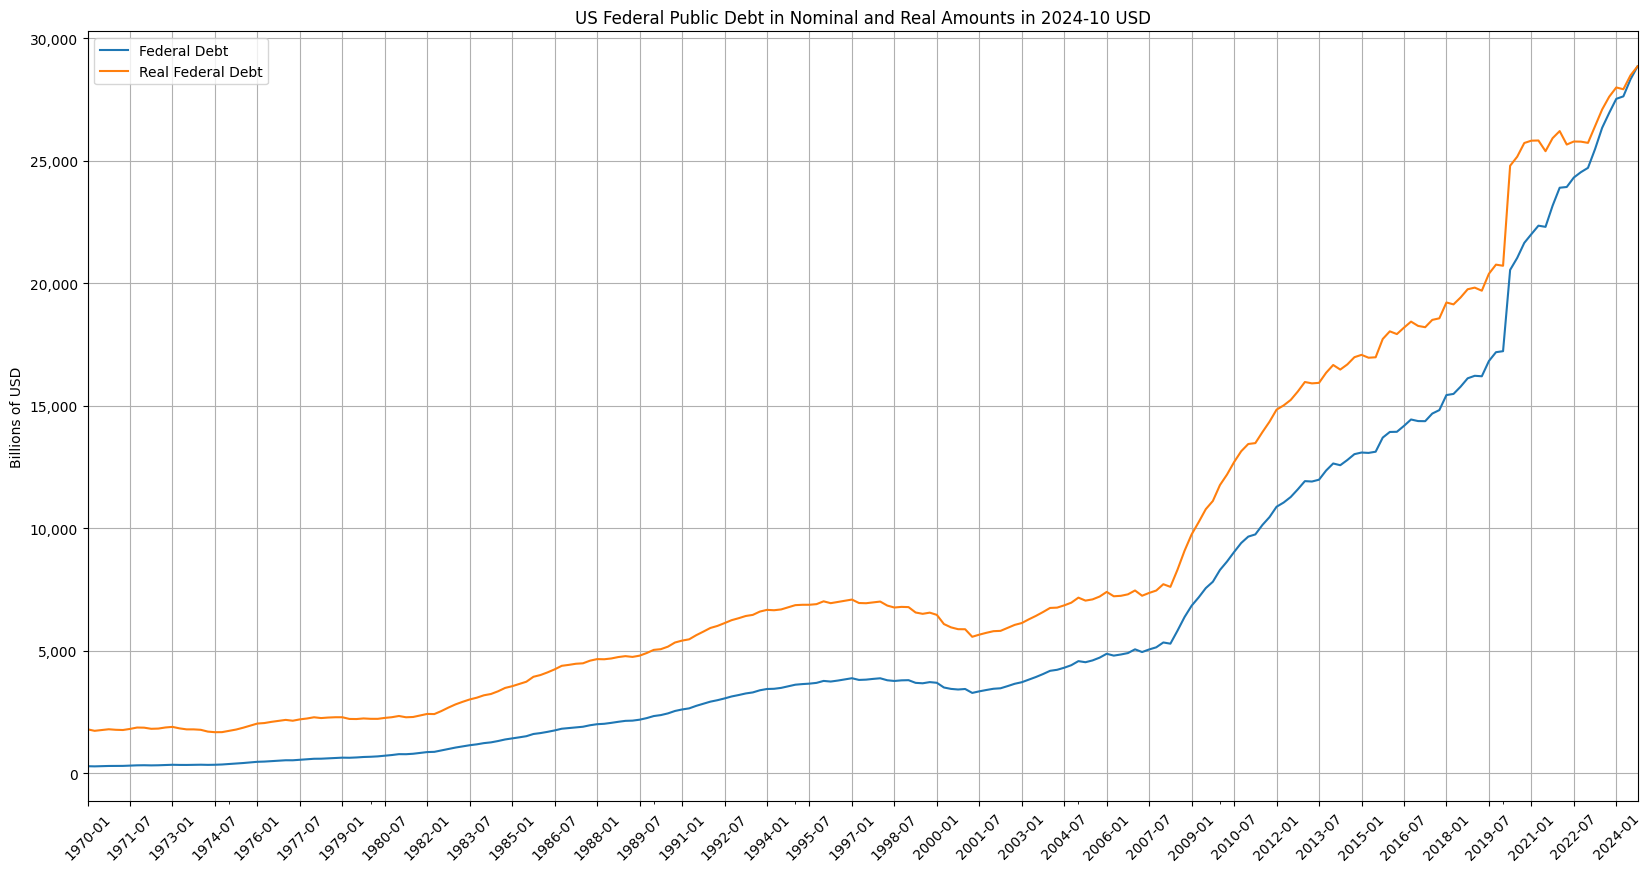

In [26]:
ax = real_pub_debt.plot(figsize=(20,10), grid=True,
    title=FEDERAL_DEBT_IN_REAL_VALUES + IN_USD_FORMATER.format(nom_2_real_conv_factors.index[-1].date()),
    xticks=real_pub_debt.index[::6], xlabel='', rot=45, ylabel=LEFT_Y_AXIS_LABEL)
#                        yticks=np.arange(0, 150, 12.5))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_pub_debt.index[::6])))

#### Zooming in on 1990 and onwards

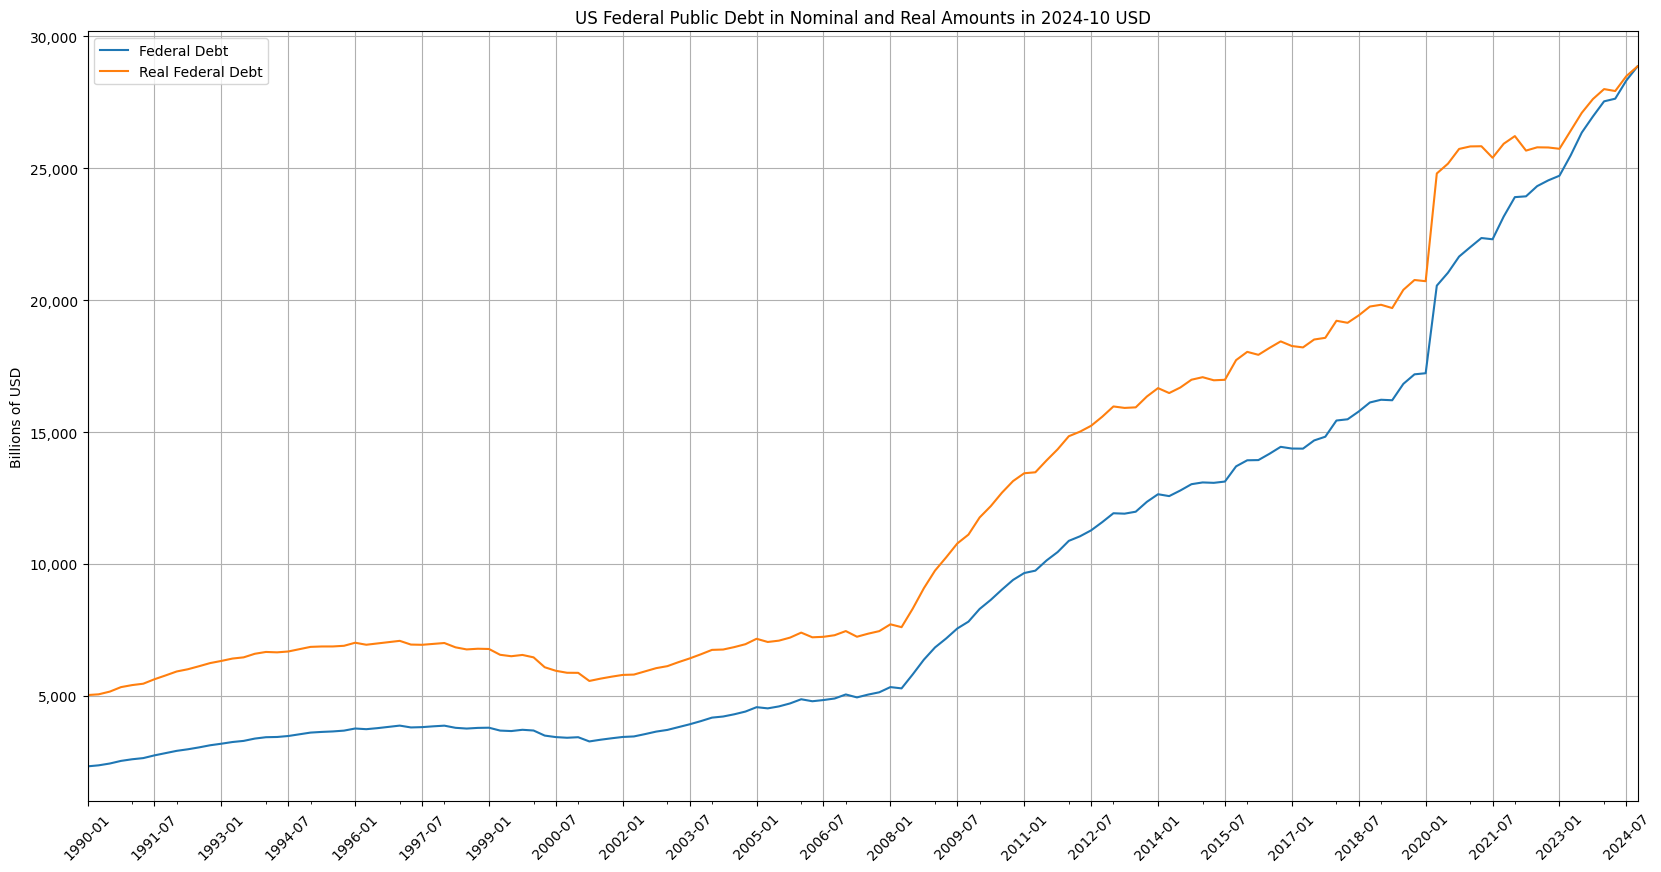

In [27]:
real_pub_debt_from_1990 = real_pub_debt.loc['1990':]
ax = real_pub_debt_from_1990.plot(figsize=(20,10), grid=True,
    title=FEDERAL_DEBT_IN_REAL_VALUES + IN_USD_FORMATER.format(nom_2_real_conv_factors.index[-1].date()),
    xticks=real_pub_debt_from_1990.index[::6], xlabel='', rot=45, ylabel=LEFT_Y_AXIS_LABEL)
#                        yticks=np.arange(0, 150, 12.5))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_pub_debt_from_1990.index[::6])))

#### Zooming in on 2008 and onwards

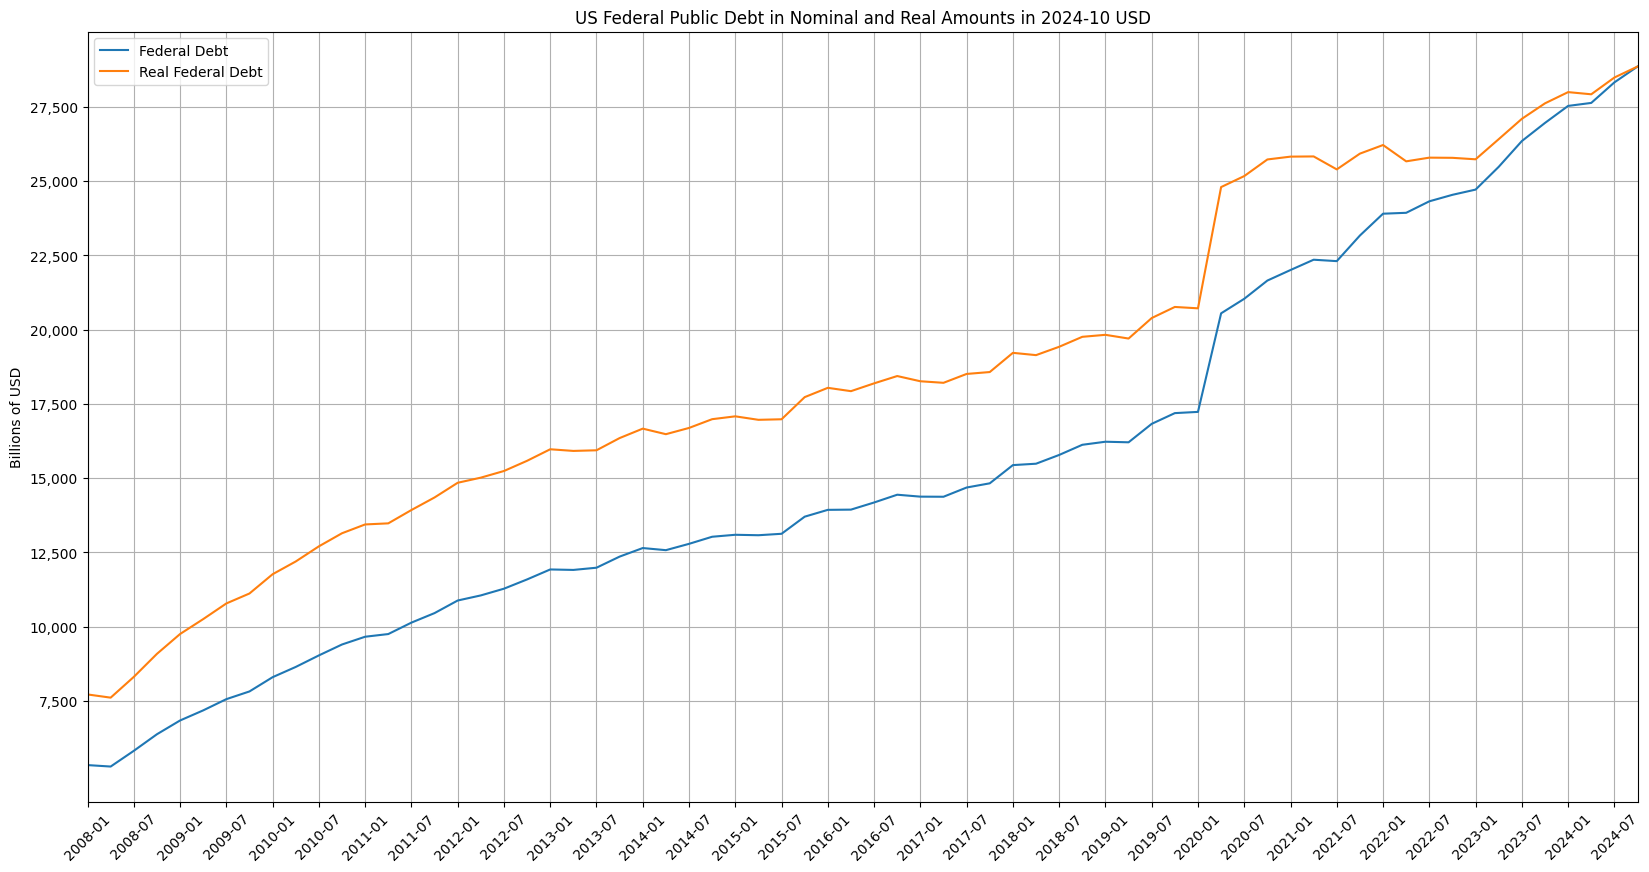

In [28]:
real_pub_debt_from_2008 = real_pub_debt.loc['2008':]
ax = real_pub_debt_from_2008.plot(figsize=(20,10), grid=True,
    title=FEDERAL_DEBT_IN_REAL_VALUES + IN_USD_FORMATER.format(nom_2_real_conv_factors.index[-1].date()),
    xticks=real_pub_debt_from_2008.index[::2], xlabel='', rot=45, ylabel=LEFT_Y_AXIS_LABEL,
    yticks=np.arange(7.5e6, 29e6, 2.5e6))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_pub_debt_from_2008.index[::2])))

In [29]:
print('Real US Federal Public Debt changed by {:+.2f}bn in quarter starting on {:%Y-%m-%d}'
      .format((real_pub_debt_from_2008.iloc[-1,1]-real_pub_debt_from_2008.iloc[-2,1]) / 1000,
              real_pub_debt_from_2008.index[-1]))

Real US Federal Public Debt changed by +369.82bn in quarter starting on 2024-10-01
